# Introduction

Takes exploratory data and fits variations of the DDM.

DDM: average-signal

Details: Take every signal that the subject saw in a trial, and average their values. Feed that into a DDM as a time-invariant signal.

## Preamble

In [1]:
# Install (package verification, PyDDM, timer, parallelization)
#!pip install paranoid-scientist
#!pip install pyddm
#!pip install pytictoc  
#!pip install pathos  

In [2]:
# Libraries
import os
from pytictoc import TicToc
import csv
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
import pyddm as ddm
from pyddm import Model, Sample, FitResult, Fittable, Fitted, ICPoint, set_N_cpus
from pyddm.models import NoiseConstant, BoundConstant, OverlayChain, OverlayNonDecision, OverlayUniformMixture, LossRobustBIC
from pyddm.functions import fit_adjust_model, display_model
import pyddm.plot

In [3]:
# Directories
datadir = "D:\\OneDrive - California Institute of Technology\\PhD\\Rangel Lab\\2023-common-consequence\\data\\processed_data"
ddmdir = "D:\\OneDrive - California Institute of Technology\\PhD\\Rangel Lab\\2023-common-consequence\\analysis\\outputs\\ddm"

In [4]:
# Run fitting?
fitting = False

In [5]:
# Parallel settings
ncpu = multiprocessing.cpu_count()-1 # always save one core
ncpu

11

## Import and Clean Raw Data

rawdata_in: odd trials used for in-sample data for model fitting.

rawdata_out: even trials used for out-sample data for model predictions.

In [6]:
# Import
data = pd.read_csv(datadir+"\\pilotdata.csv")

# Ceiling of Maximum RT for PyDDM
maxRT = math.ceil(max(data.rt))

# Display
data

,subject,trial,type,rt,p,r,vDiff_ab,choice_ab,vA,vB,choice_lr,H
0,9156374,1,AB,5.9680,0.5,0.3,-2.25,0,30,32.25,0,75
1,9156374,2,AB,3.9200,0.5,0.3,3.75,1,30,26.25,1,35
2,9156374,3,AB,4.0450,0.5,0.3,5.25,1,30,24.75,1,25
3,9156374,4,AB,4.6300,0.5,0.3,0.75,0,30,29.25,1,55
4,9156374,5,AB,5.0520,0.5,0.3,0.00,0,30,30.00,1,60
...,...,...,...,...,...,...,...,...,...,...,...,...
1439,9158924,36,ApBp,5.1217,0.7,0.7,-20.65,0,21,41.65,1,85
1440,9158924,37,ApBp,3.9959,0.7,0.7,-23.10,0,21,44.10,1,90
1441,9158924,38,ApBp,4.2567,0.7,0.7,-15.75,0,21,36.75,0,75
1442,9158924,39,ApBp,8.4685,0.7,0.7,-5.95,1,21,26.95,1,55


---
# DDM: Condition Invariant

## Fit the average stimulus DDM

In [7]:
# Create a drift subclass so drift can vary with stimulus.
class DriftRate(ddm.models.Drift):
  name = "Drift depends linearly on value difference"
  required_parameters = ["driftrate"] # Parameters we want to include in the model.
  required_conditions = ["vDiff_ab"] # The column in your sample data that modulates the parameters above.
  def get_drift(self, conditions, **kwargs):
    return self.driftrate * conditions["vDiff_ab"]

# Define the model.
model_ci = Model(name="Standard DDM that does not distinguish between AB and A'B' choices",
                 drift=DriftRate(driftrate=Fittable(minval=-1, maxval=1.5)),
                 noise=NoiseConstant(noise=Fittable(minval=.001, maxval=2)),
                 bound=BoundConstant(B=1),
                 IC=ICPoint(x0=Fittable(minval=-.99, maxval=.99)),
                 overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.1)),
                 dx=.01, dt=.01, T_dur=maxRT,  # dx: spatial grid for evidence space (-B to B, in dx bins), dt: time step in s. See Shin et al 2022 Fig 4 for why I set dx=dt.
                 choice_names=("A","B"))

In [8]:
# Interactive plot! Play with the variables!
vDiff_ab = np.sort(data.vDiff_ab.unique())
pyddm.plot.model_gui_jupyter(model=model_ci, conditions={"vDiff_ab":vDiff_ab.tolist()})

Output()

In [9]:
if fitting:

    # Only run this if specified at the start. Otherwise, just load pre-saved weights.
    print("DDM: Condition Invariant.")

    # Iterate through subjects.
    subnums = np.sort(data.subject.unique())
    for subnum in subnums:

        # Progress tracker.
        print("=========================")
        print("Subject " + str(subnum))

        # Subset the data.
        subdata = data[data["subject"]==subnum]

        # Create a sample object from our data. Sample objects are the standard input for pyDDM fitting functions.
        ddm_data = Sample.from_pandas_dataframe(subdata, rt_column_name="rt", choice_column_name="choice_ab", choice_names=("A","B"))

        # Fit the model and show it off. Keep track of how long it took to estimate the parameters.
        clock = TicToc() # Timer
        clock.tic()
        set_N_cpus(ncpu) # Parallelize
        fit_model_ci = fit_adjust_model(sample=ddm_data, model=model_ci,
                                        fitting_method="differential_evolution",
                                        lossfunction=LossRobustBIC,
                                        verbose=False)
        clock.toc("Fitting subject " + str(subnum) + " took")
        display_model(fit_model_ci)

        # Save
        filename = ddmdir + "fit_model_ci_" + str(subnum) + ".txt"
        with open(filename, "w") as f:
          f.write(repr(fit_model_ci))

## Extract parameters and BIC for the model objects

In [10]:
# Placeholders
model_ci_bic = []
model_ci_drift = []
model_ci_noise = []
model_ci_bias = []
model_ci_ndt = []

# Iterate through subjects.
subnums = np.sort(data.subject.unique())
for subnum in subnums:
    
    # Load
    filename = ddmdir + "fit_model_ci_" + str(subnum) + ".txt"
    with open(filename, "r") as f:
        model_loaded = eval(f.read())

    # Negative Log Likelihood.
    model_ci_bic.append(model_loaded.get_fit_result().value())
    
    # Fitted parameters.
    model_ci_drift.append(model_loaded.parameters()['drift']['driftrate'])
    model_ci_noise.append(model_loaded.parameters()['noise']['noise'])
    model_ci_bias.append(model_loaded.parameters()['IC']['x0'])
    model_ci_ndt.append(model_loaded.parameters()['overlay']['nondectime'])
    
d = {'bic':model_ci_bic, "drift":model_ci_drift, "noise":model_ci_noise, "bias":model_ci_bias, "ndt":model_ci_ndt}
indiv_model_ci = pd.DataFrame(data=d)
indiv_model_ci

,bic,drift,noise,bias,ndt
0,197.614476,0.051440,0.354061,-0.099547,0.094187
1,208.050035,0.016715,0.421540,0.176852,0.092509
2,235.378416,0.006016,0.400642,0.314949,0.094061
3,202.590692,0.029411,0.256057,0.017144,0.099571
4,244.179249,0.009191,0.432866,-0.149773,0.086832
5,199.171074,0.040756,0.532894,-0.050570,0.090629
6,227.957362,0.024584,0.652739,0.332271,0.001509
7,200.435388,0.017127,0.359543,-0.001355,0.095878
8,223.651085,0.034586,0.370095,-0.204548,0.080100
9,198.422078,0.009952,0.267747,0.044239,0.084693


## Means of BIC and Estimates

Confidence intervals assume normal distribution.

In [11]:
summstats_model_ci = pd.DataFrame(data={"mean":indiv_model_ci.mean(), 
                                        "se":indiv_model_ci.sem(),
                                        "ci_lower":indiv_model_ci.mean()-1.96*indiv_model_ci.sem(),
                                        "ci_upper":indiv_model_ci.mean()+1.96*indiv_model_ci.sem()}).T
summstats_model_ci

,bic,drift,noise,bias,ndt
mean,198.765020,0.028062,0.403298,-0.015494,0.087168
se,3.945812,0.002684,0.017497,0.030632,0.002967
ci_lower,191.031228,0.022801,0.369004,-0.075533,0.081353
ci_upper,206.498812,0.033323,0.437593,0.044545,0.092983


---
# DDM: Separately by Block (p,r)

## Separate datasets by type (AB or ApBp)

In [12]:
data_ab = data[data.type=="AB"]
data_apbp = data[data.type=="ApBp"]

print(data_ab.head(2))
print(data_ab.head(2))

   subject  trial type     rt    p    r  vDiff_ab  choice_ab  vA     vB  \
0  9156374      1   AB  5.968  0.5  0.3     -2.25          0  30  32.25   
1  9156374      2   AB  3.920  0.5  0.3      3.75          1  30  26.25   

   choice_lr   H  
0          0  75  
1          1  35  
   subject  trial type     rt    p    r  vDiff_ab  choice_ab  vA     vB  \
0  9156374      1   AB  5.968  0.5  0.3     -2.25          0  30  32.25   
1  9156374      2   AB  3.920  0.5  0.3      3.75          1  30  26.25   

   choice_lr   H  
0          0  75  
1          1  35  


## Generate DDM Model

In [13]:
# Create a drift subclass so drift can vary with stimulus.
class DriftRate(ddm.models.Drift):
  name = "Drift depends linearly on value difference"
  required_parameters = ["driftrate"] # Parameters we want to include in the model.
  required_conditions = ["vDiff_ab"] # The column in your sample data that modulates the parameters above.
  def get_drift(self, conditions, **kwargs):
    return self.driftrate * conditions["vDiff_ab"]

# Define the model.
model_ab = Model(name="Standard DDM fit to AB choices",
                 drift=DriftRate(driftrate=Fittable(minval=-1, maxval=1.5)),
                 noise=NoiseConstant(noise=Fittable(minval=.001, maxval=2)),
                 bound=BoundConstant(B=1),
                 IC=ICPoint(x0=Fittable(minval=-.99, maxval=.99)),
                 overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.1)),
                 dx=.01, dt=.01, T_dur=maxRT,  # dx: spatial grid for evidence space (-B to B, in dx bins), dt: time step in s. See Shin et al 2022 Fig 4 for why I set dx=dt.
                 choice_names=("A","B"))

model_apbp = Model(name="Standard DDM fit to ApBp choices",
                 drift=DriftRate(driftrate=Fittable(minval=-1, maxval=1.5)),
                 noise=NoiseConstant(noise=Fittable(minval=.001, maxval=2)),
                 bound=BoundConstant(B=1),
                 IC=ICPoint(x0=Fittable(minval=-.99, maxval=.99)),
                 overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=.1)),
                 dx=.01, dt=.01, T_dur=maxRT,  # dx: spatial grid for evidence space (-B to B, in dx bins), dt: time step in s. See Shin et al 2022 Fig 4 for why I set dx=dt.
                 choice_names=("A","B"))

In [14]:
if fitting:

    # Only run this if specified at the start. Otherwise, just load pre-saved weights.
    print("DDM: AB.")

    # Iterate through subjects.
    subnums = np.sort(data_ab.subject.unique())
    for subnum in subnums:

        # Progress tracker.
        print("=========================")
        print("Subject " + str(subnum))

        # Subset the data.
        subdata = data_ab[data_ab["subject"]==subnum]

        # Create a sample object from our data. Sample objects are the standard input for pyDDM fitting functions.
        ddm_data = Sample.from_pandas_dataframe(subdata, rt_column_name="rt", choice_column_name="choice_ab", choice_names=("A","B"))

        # Fit the model and show it off. Keep track of how long it took to estimate the parameters.
        clock = TicToc() # Timer
        clock.tic()
        set_N_cpus(ncpu) # Parallelize
        fit_model_ab = fit_adjust_model(sample=ddm_data, model=model_ab,
                                        fitting_method="differential_evolution",
                                        lossfunction=LossRobustBIC,
                                        verbose=False)
        clock.toc("Fitting subject " + str(subnum) + " took")
        display_model(fit_model_ab)

        # Save
        filename = ddmdir + "fit_model_ab_" + str(subnum) + ".txt"
        with open(filename, "w") as f:
          f.write(repr(fit_model_ab))

In [15]:
if fitting:

    # Only run this if specified at the start. Otherwise, just load pre-saved weights.
    print("DDM: ApBp.")

    # Iterate through subjects.
    subnums = np.sort(data_apbp.subject.unique())
    for subnum in subnums:

        # Progress tracker.
        print("=========================")
        print("Subject " + str(subnum))

        # Subset the data.
        subdata = data_apbp[data_apbp["subject"]==subnum]

        # Create a sample object from our data. Sample objects are the standard input for pyDDM fitting functions.
        ddm_data = Sample.from_pandas_dataframe(subdata, rt_column_name="rt", choice_column_name="choice_ab", choice_names=("A","B"))

        # Fit the model and show it off. Keep track of how long it took to estimate the parameters.
        clock = TicToc() # Timer
        clock.tic()
        set_N_cpus(ncpu) # Parallelize
        fit_model_apbp = fit_adjust_model(sample=ddm_data, model=model_apbp,
                                        fitting_method="differential_evolution",
                                        lossfunction=LossRobustBIC,
                                        verbose=False)
        clock.toc("Fitting subject " + str(subnum) + " took")
        display_model(fit_model_apbp)

        # Save
        filename = ddmdir + "fit_model_apbp_" + str(subnum) + ".txt"
        with open(filename, "w") as f:
          f.write(repr(fit_model_apbp))

## Extract estimates and BIC

In [16]:
# Placeholders
model_ab_bic = []
model_ab_drift = []
model_ab_noise = []
model_ab_bias = []
model_ab_ndt = []

# Iterate through subjects.
subnums = np.sort(data_ab.subject.unique())
for subnum in subnums:
    
    # Load
    filename = ddmdir + "fit_model_ab_" + str(subnum) + ".txt"
    with open(filename, "r") as f:
        model_loaded = eval(f.read())

    # Negative Log Likelihood.
    model_ab_bic.append(model_loaded.get_fit_result().value())
    
    # Fitted parameters.
    model_ab_drift.append(model_loaded.parameters()['drift']['driftrate'])
    model_ab_noise.append(model_loaded.parameters()['noise']['noise'])
    model_ab_bias.append(model_loaded.parameters()['IC']['x0'])
    model_ab_ndt.append(model_loaded.parameters()['overlay']['nondectime'])
    
d = {'bic':model_ab_bic, "drift":model_ab_drift, "noise":model_ab_noise, "bias":model_ab_bias, "ndt":model_ab_ndt}
indiv_model_ab = pd.DataFrame(data=d)
indiv_model_ab

,bic,drift,noise,bias,ndt
0,97.312660,0.058783,0.313904,-0.165942,0.067146
1,106.887612,0.018007,0.401901,0.201850,0.098725
2,116.778228,0.012515,0.301361,0.250897,0.074616
3,104.909972,0.031255,0.245422,0.106721,0.078875
4,125.130558,0.001427,0.392878,-0.324815,0.092661
5,95.995432,0.058460,0.561719,-0.104660,0.080221
6,123.185262,0.019538,0.542202,0.369781,0.004400
7,102.620662,0.015448,0.283405,-0.248277,0.098520
8,118.132514,0.033262,0.364450,-0.158731,0.081542
9,101.682048,0.011473,0.310702,0.026457,0.093707


In [17]:
# Placeholders
model_apbp_bic = []
model_apbp_drift = []
model_apbp_noise = []
model_apbp_bias = []
model_apbp_ndt = []

# Iterate through subjects.
subnums = np.sort(data_apbp.subject.unique())
for subnum in subnums:
    
    # Load
    filename = ddmdir + "fit_model_apbp_" + str(subnum) + ".txt"
    with open(filename, "r") as f:
        model_loaded = eval(f.read())

    # Negative Log Likelihood.
    model_apbp_bic.append(model_loaded.get_fit_result().value())
    
    # Fitted parameters.
    model_apbp_drift.append(model_loaded.parameters()['drift']['driftrate'])
    model_apbp_noise.append(model_loaded.parameters()['noise']['noise'])
    model_apbp_bias.append(model_loaded.parameters()['IC']['x0'])
    model_apbp_ndt.append(model_loaded.parameters()['overlay']['nondectime'])
    
d = {'bic':model_apbp_bic, "drift":model_apbp_drift, "noise":model_apbp_noise, "bias":model_apbp_bias, "ndt":model_apbp_ndt}
indiv_model_apbp = pd.DataFrame(data=d)
indiv_model_apbp

,bic,drift,noise,bias,ndt
0,108.010532,0.045312,0.367774,-0.048118,0.099541
1,110.054843,0.015322,0.435725,0.178335,0.098093
2,110.858334,-0.001279,0.421583,0.340519,0.090151
3,106.605127,0.028349,0.268849,0.009511,0.092376
4,102.642345,0.028829,0.334906,-0.265369,0.063802
5,110.163505,0.037922,0.498142,-0.183972,0.097209
6,102.625238,0.038103,0.794343,0.291533,0.006331
7,95.909183,0.020517,0.325959,0.242095,0.093054
8,114.542292,0.036054,0.372955,-0.259397,0.087277
9,99.339464,0.009057,0.188688,0.130763,0.090501


## Means of Estimates and BIC

In [18]:
summstats_model_ab = pd.DataFrame(data={"mean":indiv_model_ab.mean(), 
                                        "se":indiv_model_ab.sem(),
                                        "ci_lower":indiv_model_ab.mean()-1.96*indiv_model_ab.sem(),
                                        "ci_upper":indiv_model_ab.mean()+1.96*indiv_model_ab.sem()}).T
summstats_model_ab

,bic,drift,noise,bias,ndt
mean,103.000988,0.028842,0.381646,-0.036695,0.084750
se,2.399852,0.003468,0.015598,0.038260,0.002868
ci_lower,98.297278,0.022046,0.351073,-0.111685,0.079128
ci_upper,107.704698,0.035639,0.412218,0.038295,0.090372


In [19]:
summstats_model_apbp = pd.DataFrame(data={"mean":indiv_model_apbp.mean(), 
                                        "se":indiv_model_apbp.sem(),
                                        "ci_lower":indiv_model_apbp.mean()-1.96*indiv_model_apbp.sem(),
                                        "ci_upper":indiv_model_apbp.mean()+1.96*indiv_model_apbp.sem()}).T
summstats_model_apbp

,bic,drift,noise,bias,ndt
mean,99.811468,0.030059,0.385833,-0.002493,0.085445
se,2.235519,0.002753,0.020820,0.037725,0.003488
ci_lower,95.429851,0.024664,0.345026,-0.076435,0.078608
ci_upper,104.193085,0.035454,0.426639,0.071449,0.092282


## Comparing noise

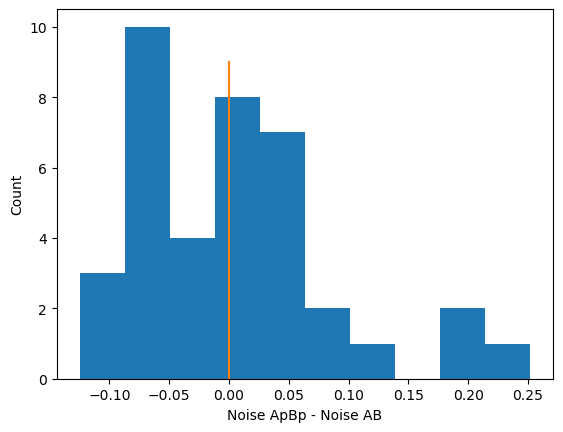

In [20]:
est_diff = indiv_model_apbp.noise - indiv_model_ab.noise
plt.hist(est_diff)
plt.plot((0, 0), (0, 9), scaley = False)
plt.xlabel("Noise ApBp - Noise AB")
plt.ylabel("Count")
plt.show()